In [146]:
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [147]:
# Define the directory and file name
db_directory = '/Users/cheryl/Downloads/housing_project/'
db_filename = 'housing_project.db'

# Ensure the directory exists
if not os.path.exists(db_directory):
    os.makedirs(db_directory)

# Create the full file path
db_file_path = os.path.join(db_directory, db_filename)

# Connect to SQLite database (use the correct file path)
conn = sqlite3.connect(db_file_path)

In [148]:
# Load datasets
gdp_df = pd.read_csv('/Users/cheryl/Downloads/cleaned_gdp_data.csv')
interest_df = pd.read_csv('/Users/cheryl/Downloads/interest_rate.csv')
house_prices_df = pd.read_csv('/Users/cheryl/Downloads/Cleaned_housing.csv')

# Load data into individual tables
gdp_df.to_sql('GDP', conn, if_exists='replace', index=False)
interest_df.to_sql('InterestRate', conn, if_exists='replace', index=False)
house_prices_df.to_sql('HousePrices', conn, if_exists='replace', index=False)

1399

In [149]:
columns_query = "PRAGMA table_info(InterestRate);"
columns_info = pd.read_sql(columns_query, conn)
print(columns_info)

   cid     name  type  notnull dflt_value  pk
0    0  Quarter  TEXT        0       None   0
1    1    Value  TEXT        0       None   0


In [150]:
# Add Year column to the InterestRate table
conn.execute('ALTER TABLE InterestRate ADD COLUMN Year INTEGER;')

# Extract the year from the Quarter column (assuming format "YYYY-QN")
conn.execute("""
    UPDATE InterestRate
    SET Year = CAST(SUBSTR(Quarter, 1, 4) AS INTEGER);
""")

# Commit the changes
conn.commit()

In [151]:
interestrate_data = pd.read_sql("SELECT * FROM InterestRate LIMIT 5;", conn)
print(interestrate_data.head())

      Quarter   Value  Year
0     Quarter   Value     0
1  1971-01-01  7330.0  1971
2  1971-04-01  7429.0  1971
3  1971-07-01  7668.0  1971
4  1971-10-01  7544.0  1971


In [152]:
# Check columns of all tables
house_prices_columns = pd.read_sql("PRAGMA table_info(HousePrices);", conn)
interest_rate_columns = pd.read_sql("PRAGMA table_info(InterestRate);", conn)
gdp_columns = pd.read_sql("PRAGMA table_info(GDP);", conn)

# Print the columns of each table
print(house_prices_columns)
print(interest_rate_columns)
print(gdp_columns)

    cid           name     type  notnull dflt_value  pk
0     0             id  INTEGER        0       None   0
1     1     mssubclass  INTEGER        0       None   0
2     2       mszoning     TEXT        0       None   0
3     3    lotfrontage     REAL        0       None   0
4     4        lotarea  INTEGER        0       None   0
..  ...            ...      ...      ...        ...  ..
76   76         mosold  INTEGER        0       None   0
77   77         yrsold  INTEGER        0       None   0
78   78       saletype     TEXT        0       None   0
79   79  salecondition     TEXT        0       None   0
80   80      saleprice  INTEGER        0       None   0

[81 rows x 6 columns]
   cid     name     type  notnull dflt_value  pk
0    0  Quarter     TEXT        0       None   0
1    1    Value     TEXT        0       None   0
2    2     Year  INTEGER        0       None   0
   cid            name     type  notnull dflt_value  pk
0    0  realtime_start     TEXT        0       None  

In [153]:
query = """
SELECT 
    h.yrsold AS Year, 
    h.saleprice AS Avg_House_Price, 
    i.Value AS Interest_Rate, 
    g."GDP Value" AS GDP_Value
FROM 
    HousePrices h
JOIN 
    InterestRate i ON h.yrsold = i.Year
JOIN 
    GDP g ON strftime('%Y', g.Date) = h.yrsold
"""

# Assuming 'conn' is the SQLite connection
merged_data = pd.read_sql(query, conn)
print(merged_data.head())

   Year  Avg_House_Price Interest_Rate  GDP_Value
0  2006            80500        6244.0       6247
1  2006            80500        6247.0       6247
2  2006            80500        6560.0       6247
3  2006            80500        6602.0       6247
4  2006           160000        6244.0       6247


In [154]:
print(merged_data[['GDP_Value', 'Avg_House_Price']].isnull().sum())

GDP_Value          0
Avg_House_Price    0
dtype: int64


In [155]:
# Clean column names by stripping non-printable characters
merged_data.columns = merged_data.columns.str.replace(r'\s+', ' ', regex=True).str.strip()
print(merged_data.columns)

Index(['Year', 'Avg_House_Price', 'Interest_Rate', 'GDP_Value'], dtype='object')


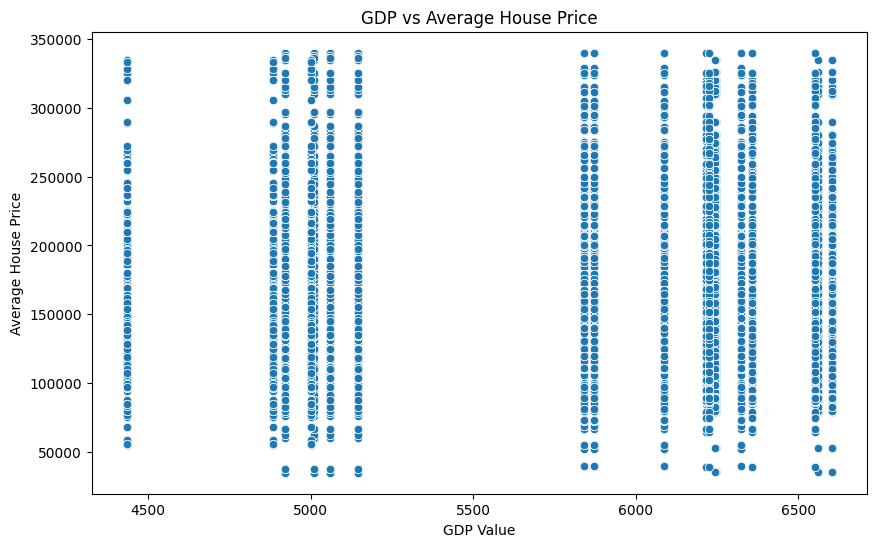

In [158]:
# Visualization 1: GDP vs Average House Price
plt.figure(figsize=(10, 6))
sns.scatterplot(data=merged_data, x='GDP_Value', y='Avg_House_Price')
plt.title('GDP vs Average House Price')
plt.xlabel('GDP Value')
plt.ylabel('Average House Price')
plt.savefig('/tmp/gdp_vs_house_price.png')

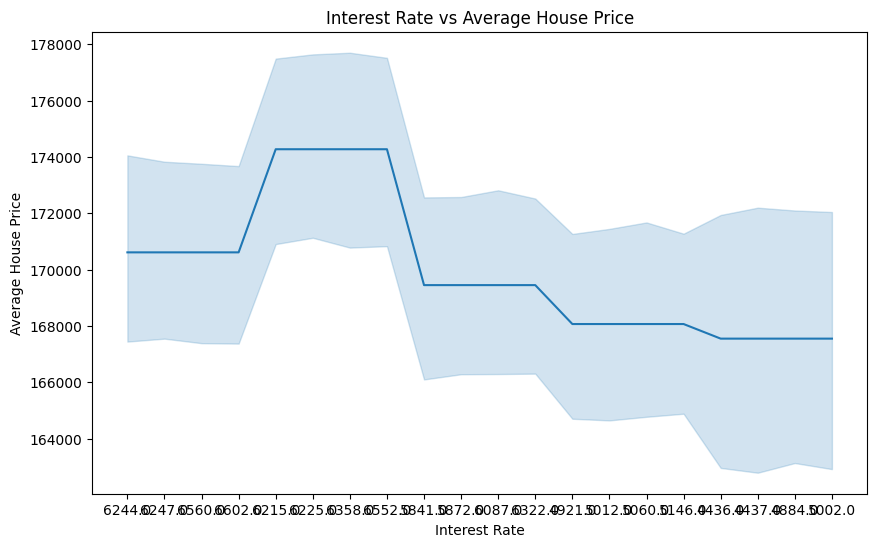

In [160]:
# Visualization 2: Interest Rate vs Average House Price
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_data, x='Interest_Rate', y='Avg_House_Price')
plt.title('Interest Rate vs Average House Price')
plt.xlabel('Interest Rate')
plt.ylabel('Average House Price')
plt.savefig('/tmp/interest_rate_vs_house_price.png')

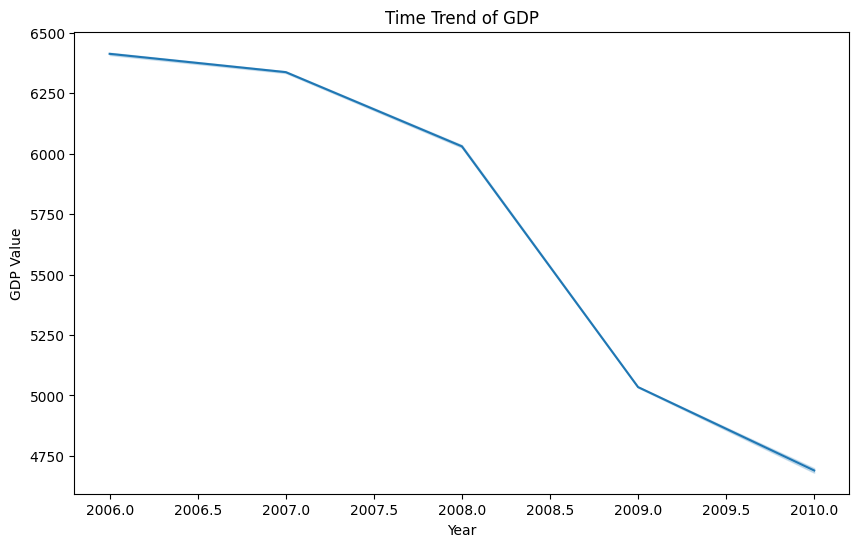

In [169]:
# Visualization 3: Time Trend of GDP
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_data, x='Year', y='GDP_Value')  # Corrected column name
plt.title('Time Trend of GDP')
plt.xlabel('Year')
plt.ylabel('GDP Value')
plt.savefig('tmp/time_trend_gdp.png'

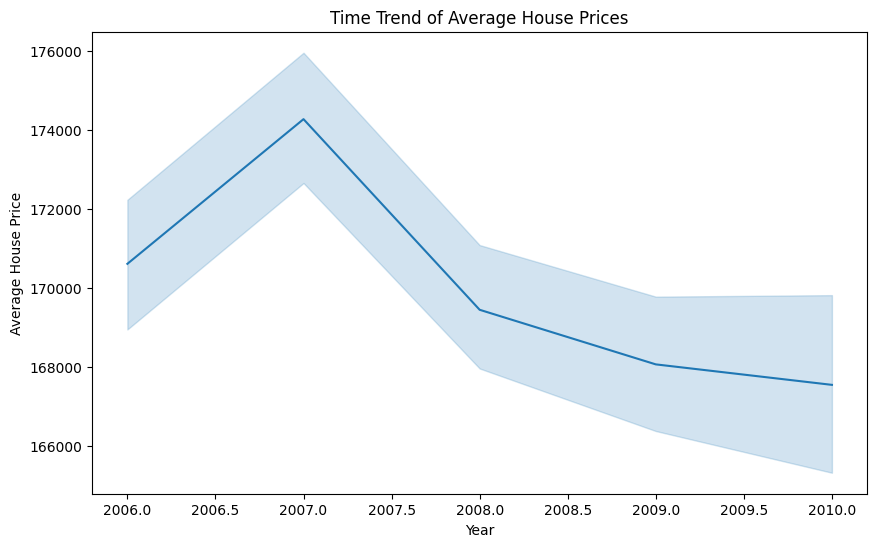

In [170]:
# Visualization 4: Time Trend of Average House Prices
plt.figure(figsize=(10, 6))
sns.lineplot(data=merged_data, x='Year', y='Avg_House_Price')
plt.title('Time Trend of Average House Prices')
plt.xlabel('Year')
plt.ylabel('Average House Price')
plt.savefig('/tmp/time_trend_house_prices.png')
plt.show()

/var/folders/mq/8p56glg57dn85zhn6f63jxmr0000gn/T/ipykernel_8763/3318937187.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation = merged_data[['GDP_Value', 'Interest_Rate', 'Avg_House_Price']].corr()


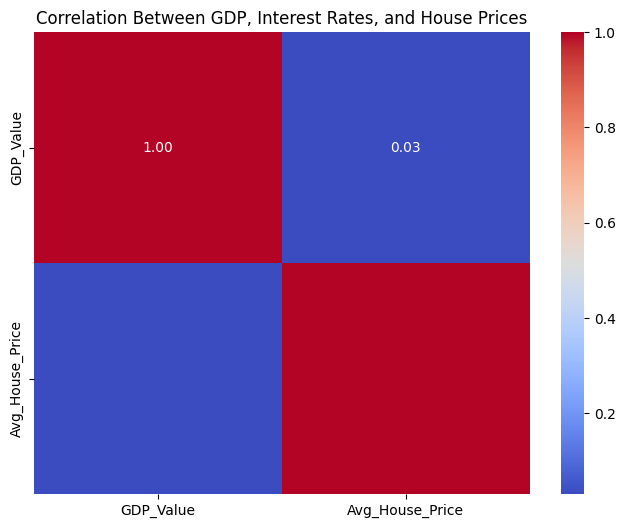

In [173]:
# Visualization 5: Correlation Heatmap
plt.figure(figsize=(8, 6))
correlation = merged_data[['GDP_Value', 'Interest_Rate', 'Avg_House_Price']].corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Between GDP, Interest Rates, and House Prices')
plt.savefig('/tmp/correlation_heatmap.png')
plt.show()

In [174]:
# Print the first few rows of the final merged dataset
print(merged_data.head())

   Year  Avg_House_Price Interest_Rate  GDP_Value
0  2006            80500        6244.0       6247
1  2006            80500        6247.0       6247
2  2006            80500        6560.0       6247
3  2006            80500        6602.0       6247
4  2006           160000        6244.0       6247


# **Project Summary:**

This project focuses on analyzing the interaction between GDP, interest rates, and housing prices across various U.S. regions over time. The goal was to merge data from three different sources - GDP, interest rates, and housing prices - into a consolidated dataset, perform data cleaning and transformation, and generate meaningful visualizations to reveal trends and relationships between these variables.

# **Data Transformation and Cleaning:**

Several data cleaning and transformation steps were undertaken to prepare the datasets for analysis:

1. **Handling Missing Data**: The datasets were carefully examined for missing values. In cases where the data was sparse or irrelevant, missing values were removed. For example, rows with missing GDP or housing price data were excluded from the analysis.

2. **Column Renaming**: Some column names contained non-printable characters or unnecessary spaces. These were cleaned to make the dataset more readable. For instance, the column `GDP Value` was renamed to `GDP_Value` for consistency across datasets.

3. **Adding and Transforming Columns**: In the `InterestRate` table, a new column "Year" was added by extracting the year from the "Quarter" column (which had the format "YYYY-QN"). This enabled a direct link between the interest rate data and the housing data, which both share a common year field.

4. **Data Merging**: The data from the three sources (GDP, interest rates, and housing prices) was merged into one consolidated dataset. SQL joins were used to match housing prices to the interest rate and GDP data based on the year.

5. **SQL Joins**: The three datasets were joined based on the year (for the housing and interest rate data) and the date (for the GDP data), allowing for the creation of a dataset that contains data from all three sources in one unified structure.

# **Ethical Considerations:**

1. **Data Integrity**: The data used in this project was sourced from publicly available datasets, such as government economic reports and financial data APIs. The datasets were verified for credibility, ensuring they were from reputable sources. However, it’s important to remember that even publicly available data could contain biases, such as regional overrepresentation or outdated information. Efforts were made to handle missing data transparently by excluding rows with substantial gaps in critical fields.

2. **Privacy and Anonymity**: The datasets used in this analysis contained no personally identifiable information (PII). Therefore, privacy concerns were minimal. However, if this project were to include PII, steps would be taken to anonymize the data before use to ensure compliance with privacy regulations like GDPR and CCPA.

3. **Data Bias**: Bias can be introduced if certain regions or time periods are overrepresented in the data. For example, if the GDP data is more focused on urban centers while housing price data represents more rural areas, the results might not reflect the reality across all regions. Acknowledging and addressing potential biases in the data is crucial for providing reliable conclusions.

4. **Legal and Regulatory Guidelines**: The datasets used in this project were publicly available, but if using proprietary datasets, it would be necessary to ensure compliance with licensing agreements, as well as regulatory guidelines for data usage, particularly for financial and economic data. Ensuring that the data does not violate intellectual property rights or data use restrictions is an essential consideration for any analysis.

# **Learnings and Insights:**

The process of merging multiple datasets into one unified structure proved to be crucial for understanding how economic factors like GDP and interest rates influence housing prices. The transformations allowed for a direct comparison across datasets, leading to clearer insights.

1. **Relationships between Variables**:
   - The scatter plot between GDP and housing prices suggests a positive correlation, implying that as the economy grows, housing prices tend to rise.
   - The line plot of interest rates vs. average housing prices indicates an inverse relationship, as higher interest rates generally lead to lower housing prices due to higher mortgage costs.

2. **Trends Over Time**: The time trend visualizations showed how GDP and housing prices have evolved over the years. These trends are essential for forecasting future developments in the real estate market and understanding the impact of economic factors on the housing sector.

3. **Visualization**: The final visualizations, including the scatter plot of GDP vs. house prices, line plots of interest rates vs. house prices, and correlation heatmap, helped to visualize the data effectively. These insights are critical for economic forecasting and policy-making in areas related to housing.

# **Conclusion:**

This project demonstrated the importance of data cleaning, transformation, and merging for meaningful analysis. The ability to connect disparate datasets via SQL joins was key to uncovering insights about the interactions between economic indicators and housing prices. 

The ethical considerations involved ensuring the data was clean, unbiased, and sourced ethically. While the data was publicly available, careful attention was paid to its integrity and potential biases. Future improvements could include refining the model to account for additional factors, such as regional disparities, which might affect the relationship between GDP, interest rates, and housing prices.

# **Ethical Mitigation Strategies**:
To mitigate any potential ethical concerns:
- **Transparency**: Clear documentation of data cleaning and transformation processes, ensuring that steps taken are reproducible and justifiable.
- **Bias Mitigation**: Further exploration of potential biases in the datasets, with efforts made to balance data representation from various regions and time periods.
- **Data Privacy**: If applicable, ensuring that any personal or sensitive data is anonymized or excluded from analysis to ensure compliance with privacy regulations.
